In [3]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import transforms
from torchvision.utils import save_image

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


sample_dir = 'samples'
if not os.path.exists(sample_dir):
    os.makedirs(sample_dir)

In [4]:
class VAE(nn.Module):
    def __init__(self, image_size=784,h_dim=400,z_dim=20):
        super(VAE, self).__init__()
        self.fc1 = nn.Linear(image_size, h_dim)
        self.fc2 = nn.Linear(h_dim, z_dim)
        self.fc3 = nn.Linear(h_dim, z_dim)
        self.fc4 = nn.Linear(z_dim, h_dim)
        self.fc5 = nn.Linear(h_dim, image_size)
        
    def encode(self,x):
        h = F.relu(self.fc1(x))
        return self.fc2(h), self.fc3(h)

    def reparameterize(self, mu, log_var):
        std = torch.exp(log_var/2)
        eps = torch.randn_like(std)
        return mu + eps*std
    
    def decode(self, z):
        h = F.relu(self.fc4(z))
        return F.sigmoid(self.fc5(h))
    
    def forward(self, x):
        mu, log_var = self.encode(x)
        z = self.reparameterize(mu,log_var)
        x_reconst = self.decode(z)
        return x_reconst, mu, log_var
        

In [31]:
image_size = 784
h_dim = 400
z_dim = 20
num_epochs = 15
batch_size = 128
learning_rate = 1e-3

transform_train = transforms.Compose([
    transforms.Resize((28,28)),
#     transforms.RandomCrop(32, padding=4),
#     transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

transform_test = transforms.Compose([
    transforms.Resize((28,28)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])
##dataloader
dataset = torchvision.datasets.ImageFolder(root='./data/cartoon', transform=transform_train)
data_loader = torch.utils.data.DataLoader(dataset=dataset, batch_size=batch_size, shuffle=True, num_workers=2)

In [32]:
dataset

Dataset ImageFolder
    Number of datapoints: 10000
    Root Location: ./data/cartoon
    Transforms (if any): Compose(
                             Resize(size=(28, 28), interpolation=PIL.Image.BILINEAR)
                             ToTensor()
                             Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
                         )
    Target Transforms (if any): None

In [33]:
import matplotlib.pyplot as plt
import numpy as np

def imgshow(img):
    img = img/2 +0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg,(1,2,0)))
    plt.show()


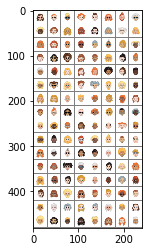

In [34]:
dataiter = iter(data_loader)
images, labels = dataiter.next()

imgshow(torchvision.utils.make_grid(images))
# print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [ ]:
model = VAE().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)   # optimize all cnn parameters
loss_record = []
show_batch = 50
for epoch in range(num_epochs):
    count = 1
    batch_loss = 0
    for i, (x, _) in enumerate(data_loader):
        x = x.to(device).view(-1, image_size)
        x_reconst, mu, log_var = model(x)
        
        reconst_loss = F.binary_cross_entropy(x_reconst, x, size_average=False)
        kl_div = -0.5*torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
        
        
        loss = reconst_loss + kl_div
        batch_loss+=loss.data.numpy()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if count % show_batch == 0:
            print(loss)
            avg_loss = float(batch_loss)/show_batch
            batch_loss = 0
            print('Epoch: ', epoch, '| loss: %.4f' % avg_loss)
            loss_record.append(avg_loss)
        count+=1
        

In [ ]:
with torch.no_grad():
    z = torch.randn(batch_size, z_dim).to(device)
    out = model.decode(z).view(-1, 1, 28, 28)
    save_image(out, os.path.join(sample_dir, 'sampled-{}.png'.format(epoch+1)))
    
    
    out, _, _ = model(x)
    x_concat = torch.cat([x.view(-1,1,28,28), out.view(-1,1,28,28)], dim=3)
    save_image(x_concat, os.path.join(sample_dir, 'reconst-{}.png'.format(epoch+1)))